In [1]:
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [11]:

import models.ENet
model = models.ENet.ENet(13, 3).to(device=device)
model_state_dict = torch.load("saved_models/ENet_680.pth")
model.load_state_dict(model_state_dict)
model.eval()

ENet(
  (initial): InitalBlock(
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (conv): Conv2d(3, 13, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (prelu): PReLU(num_parameters=16)
  )
  (bottleneck10): BottleNeck(
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv1): Conv2d(16, 4, kernel_size=(2, 2), stride=(2, 2), bias=False)
    (bn1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (prelu1): PReLU(num_parameters=1)
    (conv2): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (prelu2): PReLU(num_parameters=1)
    (conv3): Conv2d(4, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True

In [14]:

from dataloaders.NYU_loader import get_dataloaders
test_dl, train_dl = get_dataloaders(batch_size=16)

In [10]:
# Train the model
import utils.trainers.unet_train
import importlib
import utils.utils
importlib.reload(utils.trainers.unet_train)

#import models.ENet
#model = models.ENet.ENet(13, 3).to(device=device)

import models.basic_unet
model = models.basic_unet.Unet().to(device=device)

data = next(iter(train_dl))

dataloader = [data] 
optimizer = torch.optim.SGD(model.parameters(), lr=0.03)
loss_func = torch.nn.BCELoss().to(device=device)

utils.trainers.unet_train.train_Unet(model, dataloader, optimizer, loss_func=loss_func, num_epochs=1)

100%|██████████| 1/1 [00:01<00:00,  1.24s/it]

Epoch 0 loss: 0.6764298677444458


[0.6764298677444458]

In [135]:
runs = []

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12], device='cuda:0')


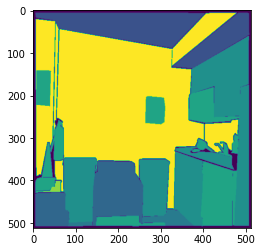

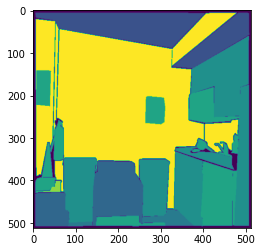

In [12]:
import importlib
data = next(iter(train_dl))
importlib.reload(utils) 

from matplotlib import pyplot as plt

x = data[0].to(device=device).float()
y = data[1].to(device=device).float()

y_one_hot = utils.utils.convert_to_one_hot(y, 13)
mask = utils.utils.convert_to_segmentation(y_one_hot)

plt.figure()
plt.imshow(y[0].cpu().squeeze(0))
plt.figure()
plt.imshow(mask[0].cpu().squeeze(0))

print(torch.unique(mask))

tensor([0.0000, 0.0769, 0.1538, 0.2308, 0.3077, 0.3846, 0.4615, 0.5385, 0.6154,
        0.6923, 0.7692, 0.8462, 0.9231, 1.0000], device='cuda:0')
tensor([ 0,  2,  3,  5,  6,  7,  8, 11, 12])


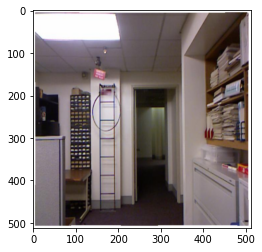

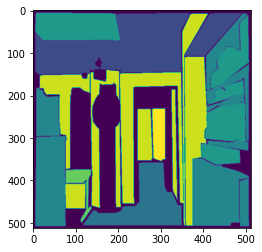

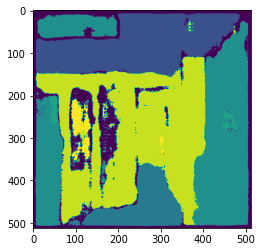

In [31]:

from skimage import color

importlib.reload(utils)

data = next(iter(train_dl))

N = 6
x = data[0].to(device=device).float()
y = data[1].to(device=device).float()[N]

pred = model(x) 

import matplotlib.pyplot as plt
import utils.utils as utils

print(torch.unique(y))

mask = utils.convert_to_segmentation(pred)

plt.figure() 
plt.imshow(x[N].cpu().permute(1, 2, 0))
plt.figure()

plt.imshow(y.cpu().squeeze(0))
plt.figure()

pred_mask = utils.convert_to_segmentation(pred) 

print(torch.unique(pred_mask[N].cpu()))

plt.imshow(pred_mask[N].cpu())


In [24]:
def test(model, dataloader):
    loss_epoch = 0
    corrects_epoch = 0
    for data in dataloader:
        x = data[0].to(device=device)
        batch_size = x.size(0)
        
        y = torch.round(data[1].to(device=device) * 12)
        preds = torch.round(model(x) * 12)
        preds = utils.convert_to_segmentation(preds)
        #print(y.shape)
        #print(preds.shape)

        corrects_epoch += torch.sum(preds.view(batch_size, -1) == y.view(batch_size, -1).data)

    epoch_acc = corrects_epoch.double() / (len(dataloader.dataset) * 512 * 512)
    print('Test accuracy {}'.format(epoch_acc))

In [32]:
test(model=model, dataloader=train_dl)

Test accuracy 0.7071927621823932
